In [1]:
import sys
from math import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
import sklearn.gaussian_process as gp
import sklearn.metrics
import keras.models
import keras.layers
import keras.preprocessing.sequence

Using TensorFlow backend.


In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    No identifier column (id or cycle) should be sent to this function!
    given dropnan=True this is how rows and columns of the output(o) of this fnuction compare to those of the input(i)
    row_o = row_i - n_in
    col_o = (col_i) * (n_in + n_out)
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# pad sequences - use for each sample sequence separately
def pad_seq(df, maxlen, mode='pre'):
        if maxlen < df.cycle.max():
                print 'the "maxlen" you chose is shorter than the current sequence. Use truncate_columns instead to truncate the sequence.', df.id.unique()
                return df
        else:
                if mode == 'pre':
                        tmp = pd.DataFrame({'cycle': range(df.cycle.max(), maxlen), 'id': df.id.unique()[0]}, columns=df.columns) #FIXME! possible off-by-one error in using range!
                        tmp = df.append(tmp).fillna(0)
                elif mode == 'post':
                        pass #FIXME!
                return tmp

# truncate sequences - use for each sample sequence separately
def truncate_seq(df, minlen, mode='post'):
    if minlen > df.cycle.max():
        print 'the "minlen" you chose is longer than the current sequence. Use pad_column instead to zero-pad the sequence.', df.id.unique()
        return df
    else:
        if mode == 'post':
            tmp = df.loc[df.cycle<=minlen]
        elif mode == 'pre':
            pass
        return tmp

In [3]:
sn = 1
setnumber = 'FD00' + str(sn)

In [4]:
# read data
print 'read data'
train = pd.read_csv('data/train_'+setnumber+'.csv')
test = pd.read_csv('data/test_'+setnumber+'.csv')


# drop the extra column
print 'drop index column'
train.drop('Unnamed: 0', 1, inplace=True)
test.drop('Unnamed: 0', 1, inplace=True)

# normalize features
print 'normalize features (using MinMaxScaler)'
train_scalables = train.loc[:,train.columns.difference(['id', 'cycle'])].values
test_scalables = test.loc[:,test.columns.difference(['id', 'cycle'])].values

train_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1)).fit(train_scalables)
test_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1)).fit(test_scalables)

train_values = train_scaler.transform(train_scalables)
test_values = test_scaler.transform(test_scalables)

train.loc[:,train.columns.difference(['id', 'cycle'])] = train_values
test.loc[:,test.columns.difference(['id', 'cycle'])] = test_values


read data
drop index column
normalize features (using MinMaxScaler)


In [5]:
# pad sequences
print 'zero-pad/truncate sequences'
train_maxlen = train.cycle.max()
train_clens = np.array([train.loc[train.id==i, 'cycle'].max() for i in train.id.unique()])
train_minlen = train_clens.min()

test_maxlen = test.cycle.max()
test_clens = np.array([test.loc[test.id==i, 'cycle'].max() for i in test.id.unique()])
test_minlen = test_clens.min()

train_minlen = test_minlen

train_padded = pd.DataFrame(columns=train.columns)
for i in train.id.unique():
    train_padded = train_padded.append(truncate_seq(train.loc[train.id==i], train_minlen))
train = train_padded

test_padded = pd.DataFrame(columns=test.columns)
for i in test.id.unique():
    test_padded = test_padded.append(truncate_seq(test.loc[test.id==i], test_minlen))
test = test_padded

zero-pad/truncate sequences


In [6]:
# read the data dimensions for the LSTM layer
train_samples = train.id.nunique()
test_samples = test.id.nunique()

train_n_in = train_minlen - 1
test_n_in = test_minlen - 1
n_out = 1

train_timesteps = train_n_in + n_out
test_timesteps = test_n_in + n_out

In [7]:
# frame as supervised learning
print 'frame sequence as supervised learning'
train_formatted = pd.DataFrame()
train_y = {}
for i in train.id.unique():
        t_in = train.loc[train.id==i, train.columns.difference(['id', 'cycle'])]
        train_y[i] = t_in.RUL.min()
        tmp = series_to_supervised(t_in.values, train_n_in, n_out, dropnan=True)
        train_formatted = train_formatted.append(tmp)
#train = train_formatted

test_formatted = pd.DataFrame()
for i in test.id.unique():
        t_in = test.loc[test.id==i, test.columns.difference(['id', 'cycle'])]
        tmp = series_to_supervised(t_in.values, test_n_in, n_out, dropnan=True)
        test_formatted = test_formatted.append(tmp)
#test = test_formatted

frame sequence as supervised learning


In [8]:
train = train_formatted

In [9]:
test = test_formatted

In [10]:
# split into input and outputs
print 'split into inputs(X) and output/labels(y)' 

train_features = int(train.shape[1]*1./train_timesteps)
test_features = int(test.shape[1]*1./test_timesteps)

train_X = train.values
test_X = test.values

test_y = pd.read_csv('original_data/RUL_'+setnumber+'.txt', header=None, names=['RUL']).RUL.values
#test_y = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(test_y)

train_y = pd.DataFrame(train_y.items(), columns=['id', 'RUL']).RUL.values
#train_y = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(train_y)

print 'reshape features to the 3D format required by Keras [samples, timesteps, features]'
train_X = train_X.reshape((train_samples, train_timesteps, train_features))
test_X = test_X.reshape((test_samples, test_timesteps, test_features))

split into inputs(X) and output/labels(y)
reshape features to the 3D format required by Keras [samples, timesteps, features]


In [11]:
# design network
bs = 10
epoch = 50
lw = 5
stack_depth = 5

model = keras.models.Sequential()

# normal LSTM layers where the internal state is updated only at the end of an epoch
for i in range(stack_depth-1):
        model.add(keras.layers.LSTM(lw, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(keras.layers.LSTM(lw, input_shape=(train_X.shape[1], train_X.shape[2])))

#FIXME! width of the final fully-connected output layer...
model.add(keras.layers.Dense(1, activation='softplus')) #more stable compared to 'relu'...
model.compile(loss='mae', optimizer='adam')
print model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 31, 5)             620       
_________________________________________________________________
lstm_2 (LSTM)                (None, 31, 5)             220       
_________________________________________________________________
lstm_3 (LSTM)                (None, 31, 5)             220       
_________________________________________________________________
lstm_4 (LSTM)                (None, 31, 5)             220       
_________________________________________________________________
lstm_5 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 1,506
Trainable params: 1,506
Non-trainable params: 0
_________________________________________________________________
None


Train on 100 samples, validate on 100 samples
Epoch 1/50
100/100 [==============================] - 1s - loss: 0.2116 - val_loss: 74.8655
Epoch 2/50
100/100 [==============================] - 0s - loss: 0.1729 - val_loss: 74.9210
Epoch 3/50
100/100 [==============================] - 0s - loss: 0.1304 - val_loss: 75.0114
Epoch 4/50
100/100 [==============================] - 0s - loss: 0.0991 - val_loss: 75.0874
Epoch 5/50
100/100 [==============================] - 0s - loss: 0.0950 - val_loss: 75.0558
Epoch 6/50
100/100 [==============================] - 0s - loss: 0.0928 - val_loss: 75.0468
Epoch 7/50
100/100 [==============================] - 0s - loss: 0.0923 - val_loss: 75.0618
Epoch 8/50
100/100 [==============================] - 0s - loss: 0.0909 - val_loss: 75.0615
Epoch 9/50
100/100 [==============================] - 0s - loss: 0.0896 - val_loss: 75.0648
Epoch 10/50
100/100 [==============================] - 0s - loss: 0.0842 - val_loss: 75.0747
Epoch 11/50
100/100 [============

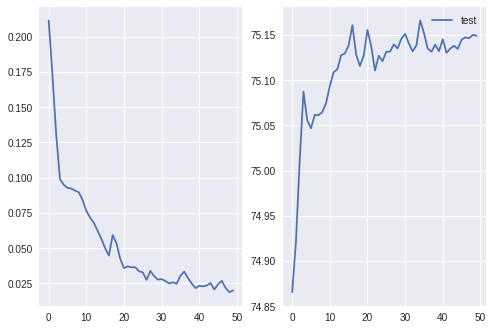

In [12]:
# fit network
history = model.fit(train_X, train_y, epochs=epoch, batch_size=bs, validation_data=(test_X, test_y), verbose=1, shuffle=True)
#history = model.fit(train_X, train_y, epochs=epoch, batch_size=bs, verbose=1, shuffle=True)
# plot history
fig, axs = plt.subplots(1,2)
axs = axs.flatten()
axs[0].plot(history.history['loss'], label='train')
axs[1].plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Test RMSE: 0.461


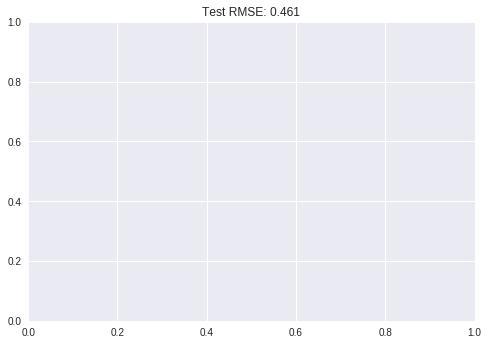

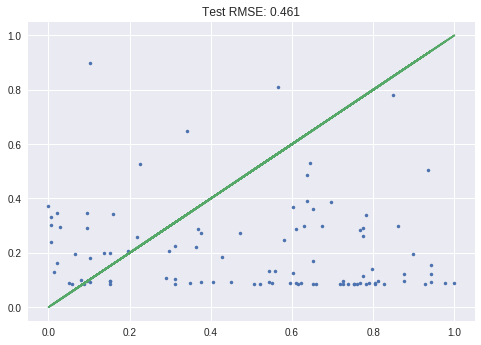

In [15]:
# make a prediction
yhat = model.predict(test_X)

# calculate RMSE
rmse = sqrt(sklearn.metrics.mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

plt.title('Test RMSE: %.3f' % rmse)
#plt.savefig('plots/'+setnumber+'_BatchSize'+str(bs)+'_Epochs'+str(epoch)+'_LayerWidth'+str(lw)+'_Stack'+str(stack_depth)+'.png')

plt.figure()
plt.plot(test_y, yhat, '.')
plt.plot(test_y, test_y, '-')
plt.title('Test RMSE: %.3f' % rmse)
plt.show()
#plt.savefig('plots/prediction.png')